In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam
from scipy.optimize import minimize

#n=np.linspace(1,190,190)
epl_1718 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1718/E0.csv") #skiprows=n para eliminar columnas
epl_1718 = epl_1718[['HomeTeam','AwayTeam','FTHG','FTAG']]
epl_1718 = epl_1718.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
#epl_1718.head()
epl_1718

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Arsenal,Leicester,4,3
1,Brighton,Man City,0,2
2,Chelsea,Burnley,2,3
3,Crystal Palace,Huddersfield,0,3
4,Everton,Stoke,1,0
...,...,...,...,...
375,Newcastle,Chelsea,3,0
376,Southampton,Man City,0,1
377,Swansea,Stoke,1,2
378,Tottenham,Leicester,5,4


<ipython-input-4-90153c116b46>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  poisson_pred = np.column_stack([[poisson.pmf(i, epl_1718.mean()[j]) for i in range(8)] for j in range(2)])


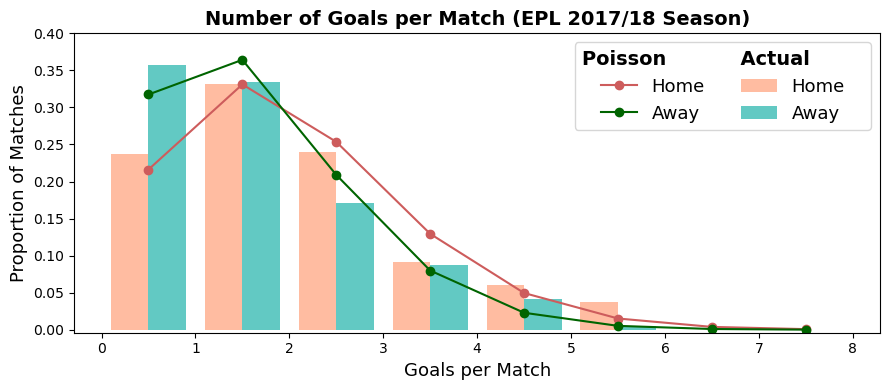

In [4]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, epl_1718.mean()[j]) for i in range(8)] for j in range(2)])

fig, ax = plt.subplots(figsize=(9,4))  
# plot histogram of actual goals
plt.hist(epl_1718[['HomeGoals', 'AwayGoals']].values, range(9), 
         alpha=0.7, label=['Home', 'Away'], color=["#FFA07A", "#20B2AA"], density=True)
()
# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

#plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (EPL 2017/18 Season)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()


In [5]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([epl_1718[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1718[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

print(poisson_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      720
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1052.3
Date:                Tue, 17 Aug 2021   Deviance:                       796.97
Time:                        08:32:52   Pearson chi2:                     683.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [6]:
poisson_model.predict(pd.DataFrame(data={'team': 'Arsenal', 'opponent': 'Southampton',
                                       'home':1},index=[1]))

1    2.426661
dtype: float64

In [7]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
ars_sou = simulate_match(poisson_model, 'Arsenal', 'Southampton', max_goals=10)
print(ars_sou[0:5, 0:5])

[[0.03726828 0.03216072 0.01387657 0.0039916  0.00086114]
 [0.09043748 0.07804317 0.03367374 0.00968627 0.0020897 ]
 [0.10973057 0.09469217 0.04085738 0.01175265 0.00253549]
 [0.08875964 0.07659527 0.033049   0.00950656 0.00205093]
 [0.05384739 0.04646769 0.02004968 0.0057673  0.00124423]]


In [8]:
from matplotlib.colors import ListedColormap

def matrix_gif(matrix, colour_matrix, colour_map, subtitle="", heatmap=False, alpha=0.8):
    fig, ax1 = plt.subplots(1, figsize=(5,5))
    if heatmap:
        ax1.matshow(matrix, alpha=alpha)
    else:
        ax1.matshow(colour_matrix, cmap=colour_map, alpha=alpha)
    ax1.tick_params(axis=u'both', which=u'both',length=0)
    ax1.grid(which='major', axis='both', linestyle='')
    ax1.set_xlabel('Away Team Goals', fontsize=12)
    ax1.set_ylabel('Home Team Goals', fontsize=12)
    ax1.xaxis.set_label_position('top')
    nrows, ncols = matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = matrix[i][j]
            ax1.text(j, i, str(round(c,4)), va='center', ha='center', size=13)
    plt.figtext(0.5, 0.05, subtitle, horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
    return fig

cmap = ListedColormap(['w', '#04f5ff', '#00ff85', '#e90052'])
matrix = simulate_match(poisson_model, 'Arsenal', 'Southampton', max_goals=5)
matn = len(matrix)
matrix_gif(matrix, matrix, ListedColormap(['w']), heatmap=True, 
           alpha=0.6, subtitle="Match Score Probability Matrix").savefig("match_matrix_0.png")
plt.close()
for t,(mat,colour,subtitle) in enumerate(zip([np.zeros((matn, matn)), np.tril(np.ones((matn,matn)),-1),
                            np.triu(np.ones((matn,matn))*2,1), np.diag([3]*matn),
                                             np.array([0 if i+j<3 else 1 for i in range(matn) for j in range(matn)]).reshape(matn,matn)],
                          ['w', '#04f5ff', '#00ff85', '#e90052','#EAF205'],
                                   ['Match Score Probability Matrix', 'Home Win', 'Away Win', 'Draw', 'Over 2.5 goals'])):
    matrix_gif(matrix, mat, ListedColormap(['w'] + [colour]), heatmap=False, 
               alpha=0.6, subtitle=subtitle).savefig("match_matrix_{}.png".format(t+1))
    plt.close()

In [9]:
def poiss_actual_diff(football_url, max_goals):
    epl_1718 = pd.read_csv(football_url)
    epl_1718 = epl_1718[['HomeTeam','AwayTeam','FTHG','FTAG']]
    epl_1718 = epl_1718.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals)] \
                 for team_avg in [epl_1718['HomeGoals'].mean(), epl_1718['AwayGoals'].mean()]]
    return np.outer(np.array(team_pred[0]), np.array(team_pred[1])) - \
        np.array([sum((epl_1718['HomeGoals']==i) & (epl_1718['AwayGoals']==j)) 
                  for i in range(max_goals) for j in range(max_goals)]).reshape((6,6))/len(epl_1718)

year_arrays = []
for year in range(2005,2018):
    year_arrays.append(poiss_actual_diff("http://www.football-data.co.uk/mmz4281/{}{}/E0.csv".format(
        str(year)[-2:], str(year+1)[-2:]),6))

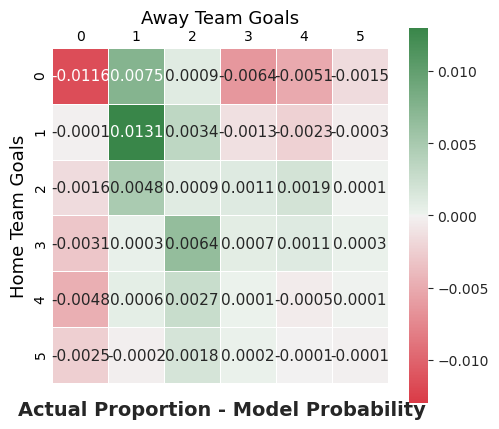

In [10]:
cmap = sns.diverging_palette(10, 133, as_cmap=True)

fig, ax = plt.subplots(figsize=(5,5))  
with sns.axes_style("white"):
    ax = sns.heatmap(np.mean(year_arrays, axis=0), annot=True, fmt='.4f', cmap=cmap, vmin=-0.013, vmax=.013, center=0.00,
                square=True, linewidths=.5, annot_kws={"size": 11}, cbar_kws={"shrink": .8})
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.grid(which='major', axis='both', linestyle='')
    ax.set_xlabel('Away Team Goals', fontsize=13)
    ax.set_ylabel('Home Team Goals', fontsize=13)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    plt.figtext(0.45, 0.1, 'Actual Proportion - Model Probability', horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
def rho_correction(x, y, lambda_x, mu_y, rho):
    if x==0 and y==0:
        return 1- (lambda_x * mu_y * rho)
    elif x==0 and y==1:
        return 1 + (lambda_x * rho)
    elif x==1 and y==0:
        return 1 + (mu_y * rho)
    elif x==1 and y==1:
        return 1 - rho
    else:
        return 1.0

In [15]:
def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
    lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
    return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
            np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

In [16]:
def solve_parameters(dataset, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['AwayTeam'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("Something's not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([0, 1.0]) # rho (score correction), gamma (home advantage)
                                     ))
    def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_paramters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like(row.HomeGoals, row.AwayGoals, score_coefs[row.HomeTeam], defend_coefs[row.HomeTeam],
                     score_coefs[row.AwayTeam], defend_coefs[row.AwayTeam], rho, gamma) for row in dataset.itertuples()]
        return -sum(log_like)
    opt_output = minimize(estimate_paramters, init_vals, options=options, constraints = constraints, **kwargs)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x))

In [17]:
params = solve_parameters(epl_1718)

<ipython-input-16-10d6cddb2998>:18: RuntimeWarning: divide by zero encountered in log
  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))
<ipython-input-16-10d6cddb2998>:17: RuntimeWarning: invalid value encountered in log
  return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) +


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1050.80074593336
            Iterations: 56
            Function evaluations: 2492
            Gradient evaluations: 56


In [18]:
params

{'attack_Arsenal': 1.447583769716188,
 'attack_Bournemouth': 0.9563468804735505,
 'attack_Brighton': 0.6846996190216688,
 'attack_Burnley': 0.6983217022696133,
 'attack_Chelsea': 1.2572034312444864,
 'attack_Crystal Palace': 0.9493959537586462,
 'attack_Everton': 0.9377701754027262,
 'attack_Huddersfield': 0.48932139373529426,
 'attack_Leicester': 1.1898935914232742,
 'attack_Liverpool': 1.5643663781976744,
 'attack_Man City': 1.7860052523896235,
 'attack_Man United': 1.330932601002322,
 'attack_Newcastle': 0.767051995936666,
 'attack_Southampton': 0.7651128167202399,
 'attack_Stoke': 0.719601419210266,
 'attack_Swansea': 0.46645368048752106,
 'attack_Tottenham': 1.4273387359236986,
 'attack_Watford': 0.9338876250063981,
 'attack_West Brom': 0.5837348569070554,
 'attack_West Ham': 1.044978121173092,
 'defence_Arsenal': -0.9057931801505837,
 'defence_Bournemouth': -0.7584693817739929,
 'defence_Brighton': -0.8946013452472893,
 'defence_Burnley': -1.2266950743514513,
 'defence_Chelsea': 

In [19]:
def calc_means(param_dict, homeTeam, awayTeam):
    return [np.exp(param_dict['attack_'+homeTeam] + param_dict['defence_'+awayTeam] + param_dict['home_adv']),
            np.exp(param_dict['defence_'+homeTeam] + param_dict['attack_'+awayTeam])]

def dixon_coles_simulate_match(params_dict, homeTeam, awayTeam, max_goals=10):
    team_avgs = calc_means(params_dict, homeTeam, awayTeam)
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in team_avgs]
    output_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    correction_matrix = np.array([[rho_correction(home_goals, away_goals, team_avgs[0],
                                                   team_avgs[1], params['rho']) for away_goals in range(2)]
                                   for home_goals in range(2)])
    output_matrix[:2,:2] = output_matrix[:2,:2] * correction_matrix
    return output_matrix

In [20]:
ars_sou_dc = dixon_coles_simulate_match(params, 'Arsenal', 'Southampton', max_goals=10)

In [23]:
g=10
match =  dixon_coles_simulate_match(params, 'Arsenal', 'Southampton', g)
M=match

d = np.trace(match)*100;        #draw

s=0;
for i in range(1,g):
    for j in range(0,i):
        s=s+M[i][j]
        #print (M[i][j])
hw=s*100;                      #home win
print (' ')
s=0;
for i in range(0,g):
    for j in range(i+1,g):
        s=s+M[i][j]
        #print (M[i][j])
aw=s*100;                      #away win

print (hw,d,aw);


 
70.93235648139795 18.60794108757845 10.436716968544317


In [81]:
m=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRPcOgOaE8MDbRJp06B50CcHGhKQoK20OZvHJy37IhgELRondZjvQCQZHYMI65FFBQqt4rCiDURmsMR/pub?output=csv',header=None)
m = pd.DataFrame(m)

for i in range(3):
    
    ht = m.loc[i,0]
    at = m.loc[i,1]
    print (ht,at)
    match =  dixon_coles_simulate_match(params, ht, at, g)

    M=match

    d = np.trace(match)*100;        #draw

    s=0;
    for i in range(1,g):
        for j in range(0,i):
            s=s+M[i][j]
            #print (M[i][j])
    hw=s*100;                      #home win

    s=0;
    for i in range(0,g):
        for j in range(i+1,g):
            s=s+M[i][j]
            #print (M[i][j])
    aw=s*100;                      #away win

    print (hw,d,aw);
    print ('')

Chelsea Arsenal
51.33431731375986 24.90809751072524 23.75435223987053

Tottenham Leicester
72.90024084423527 17.14002571375942 9.91871046897045

Man City Man United
57.87434287868525 26.06685378235581 16.05723971853334



In [7]:
import os

file = open("ojoconel2022.txt", "w")
file.write("Primera línea" + os.linesep)
file.write("Segunda línea")
file.close()

In [1]:
from pydrive.auth import GoogleAuth

gauth = GoogleAuth()
#gauth.LocalWebserverAuth()

In [4]:
gauth.SaveCredentialsFile("mycreds.txt")

NameError: name 'gauth' is not defined

In [2]:
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth

drive = GoogleDrive(gauth)
gauth = GoogleAuth()
gauth.LoadCredentialsFile("mycreds.txt")

In [10]:
#file = drive.CreateFile({'title': 'My Awesome File.txt'})
#file = drive.CreateFile({'title':'premier.txt'})
#file.SetContentString('Hello World!') # this writes a string directly to a file
#file.SetContentFile('/bets')
#file.Upload()

file1 = drive.CreateFile()
file1.SetContentFile('C:\Users\pcusb\Desktop\sport-bets/ojoconel2022.txt')
file1.Upload()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-10-41d4d6425c18>, line 8)

In [3]:
file2 = drive.CreateFile({'parents': [{'id': '### folder ID ###'}]})

folderName = 'bets'  # Please set the folder name.

folders = drive.ListFile({'q': "title='" + folderName + "' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()

for folder in folders:
    if folder['title'] == folderName:
        file2 = drive.CreateFile({'parents': [{'id': folder['id']}]})
        file2.SetContentFile('premier.txt')
        file2.Upload()


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=435484700847-n0qd8kom0dsnn014q4hs7r6m7ni9o60g.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [8]:
file_list = drive.ListFile({'q': "title contains 'premier.txt' and trashed=false"}).GetList()
print(file_list[0]['title']) # should be the title of the file we just created
file_id = file_list[0]['id'] # get the file ID
print (file_id)

file = drive.CreateFile({'id': file_id})
file.Delete()

#file_list = drive.ListFile({'q': 'trashed=false'}).GetList()

#for file in file_list:
 #   print(file['title'], file['id']);

premier.txt
1VpWzc8e1p3njCixFfLY-h-7yYRye9ovm
